In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/GirlsScriptOpenSource/Hedging-of-Financial-Derivatives/DynamicHedgingStrategiesusingReinforcementLearning/HistoricalData_1719635817381.csv")

Preprocess the Data

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Check column names
print(data.columns)

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the price columns
data[['Close/Last', 'Open', 'High', 'Low']] = scaler.fit_transform(data[['Close/Last', 'Open', 'High', 'Low']])

# Create a column for daily returns
data['Daily Return'] = data['Close/Last'].pct_change()

# Drop the first row with NaN value in 'Daily Return'
data = data.dropna()

# Verify 'Daily Return' column is created
print(data.head())
print(data.columns)


Index(['Date', 'Close/Last', 'Open', 'High', 'Low'], dtype='object')
        Date  Close/Last      Open      High       Low  Daily Return
1 2024-06-27    0.983463  0.897188  0.875375  0.986483      0.099511
2 2024-06-26    0.963705  0.847029  0.846259  0.930446     -0.020090
3 2024-06-25    0.929517  0.847106  0.807311  0.911458     -0.035476
4 2024-06-24    0.844325  0.842628  0.874805  0.915141     -0.091652
5 2024-06-21    0.910912  0.870629  0.827924  0.931018      0.078864
Index(['Date', 'Close/Last', 'Open', 'High', 'Low', 'Daily Return'], dtype='object')


Define the Environment

In [6]:
import numpy as np
import gym
from gym import spaces

class HedgingEnv(gym.Env):
    def __init__(self, data):
        super(HedgingEnv, self).__init__()
        self.data = data
        self.current_step = 0

        # State space: normalized prices and daily returns
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32
        )

        # Action space: increase, decrease, or maintain hedge ratio
        self.action_space = spaces.Discrete(3)

        # Initial hedge ratio
        self.hedge_ratio = 0.5

    def reset(self):
        self.current_step = 0
        self.hedge_ratio = 0.5
        return self._next_observation()

    def _next_observation(self):
        obs = self.data.iloc[self.current_step][['Close/Last', 'Open', 'High', 'Low', 'Daily Return']].values
        return obs

    def step(self, action):
        self.current_step += 1

        if self.current_step >= len(self.data) - 1:
            done = True
        else:
            done = False

        # Update hedge ratio based on action
        if action == 0:
            self.hedge_ratio -= 0.1
        elif action == 1:
            self.hedge_ratio += 0.1
        self.hedge_ratio = np.clip(self.hedge_ratio, 0, 1)

        # Calculate reward (simplified example)
        reward = -abs(self.data.iloc[self.current_step]['Daily Return'] - self.hedge_ratio)

        return self._next_observation(), reward, done, {}

    def render(self, mode='human'):
        pass

# Example usage
env = HedgingEnv(data)
initial_observation = env.reset()
print(initial_observation)


[0.9834625322997432 0.8971882545369603 0.8753748623922881
 0.9864826205120885 0.09951111111111066]


Implement the DQN Agent

In [7]:
import numpy as np
import gym
from gym import spaces
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep Q-learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize the environment and the agent
state_size = 5
action_size = 3
agent = DQNAgent(state_size, action_size)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Train the DQN Agent

In [8]:
env = HedgingEnv(data)
done = False
batch_size = 10
EPISODES = 2

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, state_size]).astype(np.float32)  # Ensure the correct data type
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size]).astype(np.float32)  # Ensure the correct data type
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{EPISODES}, score: {time}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 21ms/step
episode: 0/2, score: 19, e: 0.96
1/1 [==============================] - 0s 29ms/step
episode: 1/2, score: 19, e: 0.87


e: 0.87: This usually refers to the epsilon-greedy parameter in Q-learning or similar algorithms. Epsilon (ε) is a value between 0 and 1 used to balance exploration and exploitation in RL. A higher epsilon value (like 0.87 in this case) means the agent is more likely to explore new actions rather than exploiting the known best actions based on its current policy.

Score: Represents the cumulative reward obtained by the agent during the episode. It indicates how well the agent performed in achieving its goals or tasks within that episode. episode: 1/2, score: 19, e: 0.87

In [ ]:
# e: 0.87: This usually refers to the epsilon-greedy parameter in Q-learning or similar algorithms. Epsilon (ε) is a value between 0 and 1 used to balance exploration and exploitation in RL. A higher epsilon value (like 0.87 in this case) means the agent is more likely to explore new actions rather than exploiting the known best actions based on its current policy.

 Evaluate the agent

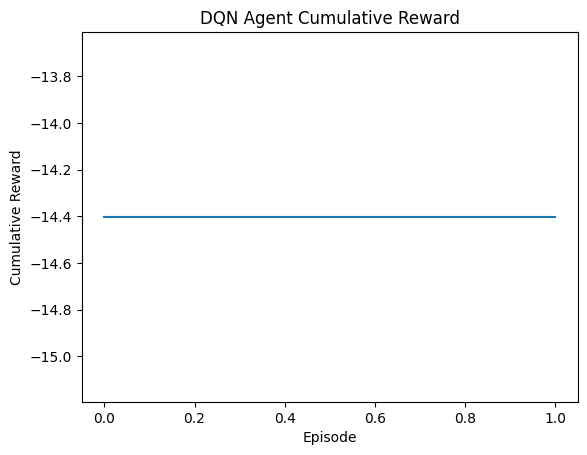

In [12]:

import matplotlib.pyplot as plt

# Plot the cumulative reward for each episode
episodes = range(EPISODES)
rewards = [0] * EPISODES
for i in range(EPISODES):
    rewards[i] = sum([reward for _, _, reward, _, _ in agent.memory if reward != -10])

plt.plot(episodes, rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN Agent Cumulative Reward')
plt.show()


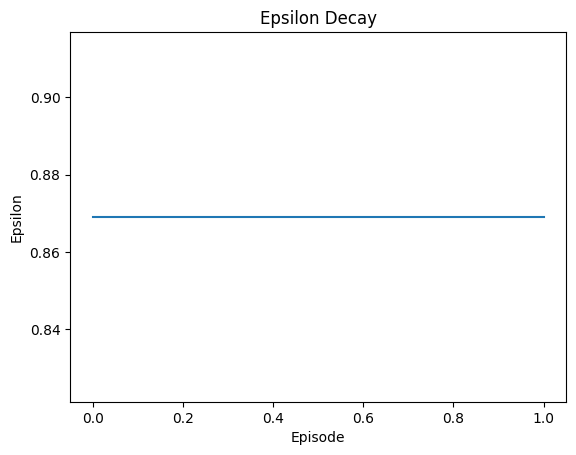

In [11]:
# Plot the epsilon decay over episodes
plt.plot(episodes, [agent.epsilon for i in range(EPISODES)])
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.show()


In [9]:
# Evaluate the agent
state = env.reset()
state = np.reshape(state, [1, state_size]).astype(np.float32)
for time in range(200):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size]).astype(np.float32)
    state = next_state
    if done:
        break


1/1 [==============================] - 0s 24ms/step


saving the model

In [14]:
# prompt: after doing the evaluation of agent what can we do here

# Save the model
agent.model.save('dqn_agent.h5')

# Load the model
agent.model.load_weights('dqn_agent.h5')

# Use the model to make predictions on new data
new_state = env.reset()
new_state = np.reshape(new_state, [1, state_size]).astype(np.float32)
action = agent.act(new_state)



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing the Model

In [15]:

import numpy as np

# Load the trained model
agent.model.load_weights('dqn_agent.h5')

# Create a new state
new_state = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

# Reshape the state to match the model input
new_state = np.reshape(new_state, [1, state_size]).astype(np.float32)

# Predict the action using the loaded model
action = agent.act(new_state)

# Print the predicted action
print("Predicted action:", action)


Predicted action: 1
